In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import lime
from lime.lime_tabular import RecurrentTabularExplainer
import glog
import numpy as np
import pandas as pd
import sklearn
import shap
import joblib

import sys
sys.path.append("../")
import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import base_io

%matplotlib inline

In [2]:
shap.initjs() 

## 0 Load Model

In [7]:
future_index = 'IC'
from model_layer.model_hub import LSTM
params = base_io.load_best_params(future_index, LSTM.name)
train_data, val_data, test_data = base_io.load_data('IC')
train_dataset, val_dataset, test_dataset = base_io.get_dataset('IC', params=params)
train_x = np.array(train_dataset.data_x)
test_x =  np.array(test_dataset.data_x)
train_y = np.array(train_dataset.data_y)
test_y =  np.array(test_dataset.data_y)

In [8]:
model_path = '../model_layer/trained_models/IC/LSTM.pth'
model = LSTM(
    input_size=len(train_dataset.features_list),
    hidden_size=params['hidden_size'],
    num_layers=params['num_layers'],
    fc_size=params['fc_size'],
    output_size=xfinai_config.model_config['LSTM']['output_size'],
    dropout_prob=params['dropout_prob'],
    device='cpu'
)
model.load_state_dict(torch.load(model_path))

W0329 12:15:46.384625 25552 warnings.py:109] dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16621672979785956 and num_layers=1



<All keys matched successfully>

## 1 PPD

In [9]:
def cerate_data_loader(data, params):
    dataset = FuturesDatasetRecurrent(data=data, label=xfinai_config.label, seq_length=params['seq_length'])
    loader = DataLoader(dataset=dataset, **xfinai_config.data_loader_config, batch_size=params['batch_size'])
    return loader

In [10]:
def pred_func(train_data):
    
    full_batch_num = train_data.shape[0] // np.lcm(params['batch_size'], params['seq_length'])
    full_batch_num +=1
    
    padded_num = full_batch_num * np.lcm(params['batch_size'], params['seq_length']) - train_data.shape[0] + params['seq_length']
    train_data_sub = train_data.iloc[-padded_num:]
    train_data_padded = pd.concat([train_data, train_data_sub])
    
    train_data_loader = cerate_data_loader(train_data_padded, params)
    pre_result = np.array([])

    with torch.no_grad():
        for idx, (x_batch, y_batch) in enumerate(train_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            y_pred = model(x_batch)
            pre_result = np.append(pre_result, y_pred)
    
    pre_result_unpadded = pre_result[:-(padded_num-params['seq_length'])]
    
    
    return pre_result_unpadded

In [3]:
# explainer = shap.Explainer(partial(pred_func), train_data_sample)
# shap_values = explainer(train_data_sample)
shap_values = joblib.load("./shap_values/IC_LSTM_first_barch.pkl")

In [11]:
train_data_sample = train_data.iloc[:64]

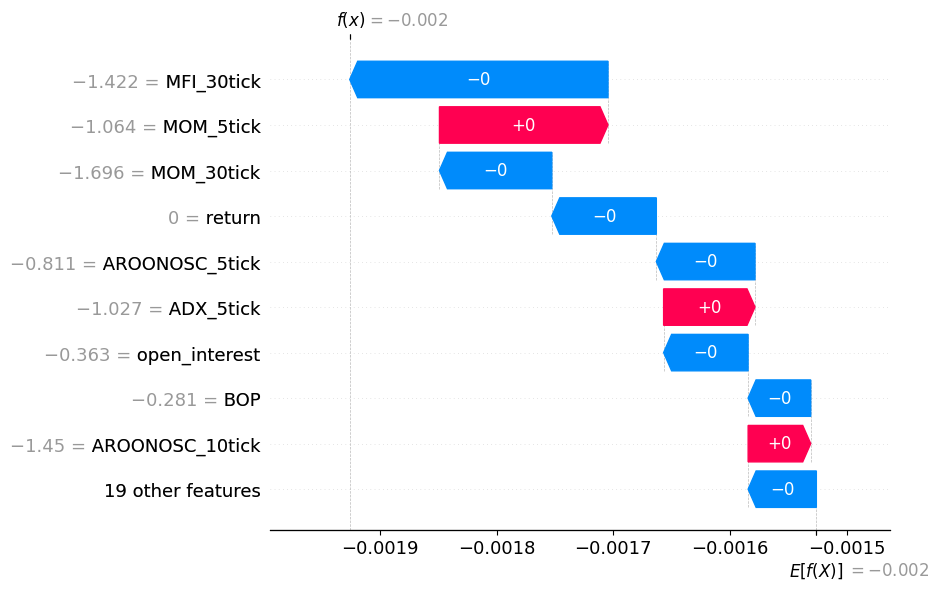

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=[6,4], dpi=100)
shap.plots.waterfall(shap_values[10], max_display=10)

In [30]:
shap.force_plot(shap_values[10,:], train_data_sample.iloc[10,:])

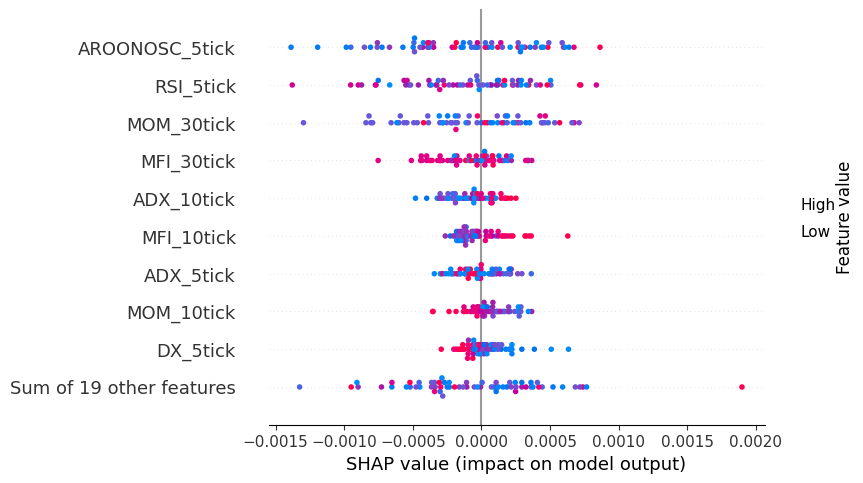

In [31]:
plt.figure(figsize=[6,4], dpi=100)
shap.plots.beeswarm(shap_values, max_display=10)